In [ ]:
# imports and install

# !pip install scipy==1.1.0
# !pip install keras-vis
# !pip install keras==2.2.2
# !pip install tensorflow==1.15
# !pip install keras_applications==1.0.7
# !pip install git+https://github.com/raghakot/keras-vis.git -U

import os
import keras
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras import activations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency,visualize_activation
from vis.utils import utils
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
# load data into memory.
base_path = "required_2D_Data"
extension = '.png'
num_classes = 2

X = []
Y = []
for file in os.listdir(base_path):
    if file.endswith(extension):
        image_path = os.path.join(base_path, file)
        image = load_img(image_path)
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)
        X.append(x)
        label = file.split('_')[0]
        if(label=='AD'):
            Y.append(0)
        if(label=='MCI'):
            Y.append(0)
        if(label=='MCI2AD'):
            Y.append(0)
        if(label=='MCI2NC'):
            Y.append(1)
        if(label=='NC'):
            Y.append(1)

In [ ]:
X = np.array(X).reshape(-1, 288, 432, 3)
X = X.astype('float32')
X = X / 255.
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [ ]:
# model
model = keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(288, 432, 3), name='layer_1'))
model.add(MaxPooling2D((2, 2), name='layer_2'))
model.add(Dropout(0.25, name='layer_3'))
model.add(Conv2D(64, (3, 3), activation='relu', name='layer_4'))
model.add(MaxPooling2D((2, 2), name='layer_5'))
model.add(Dropout(0.25, name='layer_6'))
model.add(Conv2D(64, (3, 3), activation='relu', name='layer_7'))
model.add(Flatten(name='layer_8'))
model.add(Dense(64, activation='relu', name='layer_9'))
model.add(Dense(2, activation='softmax', name='visualized_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Conv2D)             (None, 286, 430, 32)      896       
_________________________________________________________________
layer_2 (MaxPooling2D)       (None, 143, 215, 32)      0         
_________________________________________________________________
layer_3 (Dropout)            (None, 143, 215, 32)      0         
_________________________________________________________________
layer_4 (Conv2D)             (None, 141, 213, 64)      18496     
_________________________________________________________________
layer_5 (MaxPooling2D)       (None, 70, 106, 64)       0         
_________________________________________________________________
layer_6 (Dropout)            (None, 70, 106, 64)       0         
_________________________________________________________________
layer_7 (Conv2D)             (None, 68, 104, 64)       36928     
__________

In [ ]:
# compile model
import tensorflow as tf

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(np.array(X_train), np.array(Y_train), epochs=5, 
                    validation_data=(np.array(X_test), np.array(Y_test)))

Train on 379 samples, validate on 43 samples
Epoch 1/5
379/379 [==============================] - 97s 255ms/step - loss: 0.6360 - acc: 0.9789 - val_loss: 0.6854 - val_acc: 1.0000
Epoch 2/5
379/379 [==============================] - 94s 248ms/step - loss: 0.6404 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
Epoch 3/5
379/379 [==============================] - 95s 250ms/step - loss: 0.6404 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
Epoch 4/5
379/379 [==============================] - 94s 249ms/step - loss: 0.6404 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
Epoch 5/5
379/379 [==============================] - 94s 249ms/step - loss: 0.6404 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000


In [ ]:
score = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
model.save("2dCNN.h5")

In [ ]:
# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'visualized_layer')

# Swap softmax with linear
model.layers[layer_index].activation = activations.linear

ValueError: ignored

In [ ]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved model to disk")
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
acc: 100.00%


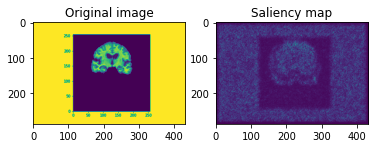

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# Matplotlib preparations
fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(15,15))
# Generate visualization
visualization = visualize_saliency(loaded_model, layer_index, filter_indices=None, seed_input=img, backprop_modifier=None)
axes[0].imshow(X_test[0][..., 0]) 
axes[0].set_title('Original image')
axes[1].imshow(visualization)
axes[1].set_title('Saliency map')
plt.show()

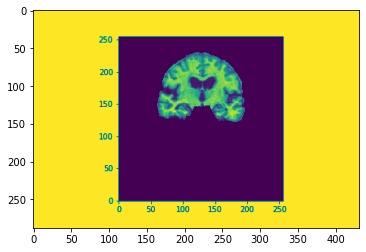

In [ ]:
filter_idx = 0
img = visualize_activation(loaded_model, layer_index, filter_indices=filter_idx)
plt.imshow(X_test[0][..., 0])

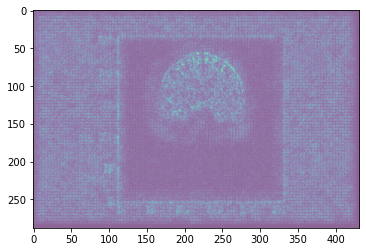

In [ ]:
grads = visualize_saliency(loaded_model, layer_index, filter_indices=None,
                          seed_input=X_test[0], backprop_modifier=None)
plt.imshow(grads, alpha=0.6)

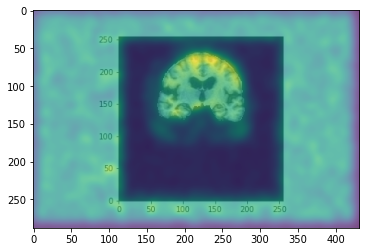

In [ ]:
gaus = ndimage.filters.gaussian_filter(grads[:,:], sigma=5)
plt.imshow(X_test[0])
plt.imshow(gaus, alpha=0.7)